### Generic imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time
import math
import random
import pandas as pd
import matplotlib as mpl
import numpy as np
from skimage import io
from skimage import filters
from random import sample

### Create DF from dataset using images in folder

In [2]:
DATASET_TRAIN_PATH = './DataSet/train/'
DATASET_TEST_PATH = './DataSet/test/'
TRAIN_SIZE = 5000

def preprocess_image(image_flat):
    image_view = image_flat.reshape(128,128)
    filtered_image = filters.median(image_view)
    sobel = filters.sobel(filtered_image)
    final_image = sobel.flatten()
    return final_image

def create_df_from_images(ds_path,nbinstances,preprocess=False):
    
    files = os.scandir(ds_path)
    train = pd.DataFrame(columns=['file_name','image','nbfinger','hand'])

    for idx,file in enumerate(files):
        if not file.name.startswith('.') and file.is_file() and file.name.endswith('.png') and idx<nbinstances:
            fname = file.name
            complete_fname = os.path.join(ds_path,fname)
            root,ext = os.path.splitext(fname)
            image = io.imread(complete_fname,as_gray=True)
            flat_image = image.flatten()
            if preprocess: 
                processed_image = preprocess_image(flat_image)
            else:
                processed_image = flat_image
            train.loc[idx,'file_name'] = fname
            train.loc[idx,'image'] = processed_image
            train.loc[idx,'nbfinger'] = root[-2:-1]
            train.loc[idx,'hand'] = root[-1:]
            train.loc[idx,'fingerhand'] = root[-2:]
            
#     train['nbfinger'] = train['nbfinger'].astype('category')
#     train['hand'] = train['hand'].astype('category')
    return train

t1 = time.time()
train = create_df_from_images(DATASET_TRAIN_PATH,TRAIN_SIZE)
test = create_df_from_images(DATASET_TEST_PATH,TRAIN_SIZE//5)
t2 = time.time()
print('dataset created in %.2f seconds' %(t2 - t1))

dataset created in 16.76 seconds


### Data exploration

Check repartition of images among categories - should be same for all

In [3]:
train['nbfinger'].value_counts()

2    871
4    846
5    837
0    830
3    810
1    806
Name: nbfinger, dtype: int64

In [4]:
train['hand'].value_counts()

L    2532
R    2468
Name: hand, dtype: int64

In [5]:
train['fingerhand'].value_counts()

2L    452
5L    430
4R    426
4L    420
2R    419
0R    419
3L    418
0L    411
5R    407
1R    405
1L    401
3R    392
Name: fingerhand, dtype: int64

### Visualization

Display random image

file_name           1fe534ba-7b92-4b74-a4dd-5abb42902ba6_3R.png
image         [40, 44, 53, 53, 46, 41, 39, 41, 45, 48, 47, 4...
nbfinger                                                      3
hand                                                          R
fingerhand                                                   3R
Name: 2322, dtype: object


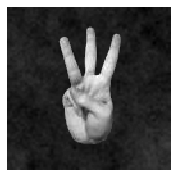

In [3]:
def plot_image(image):
    size = int(math.sqrt(len(image)))
    image_view = image.reshape(size,size)
    plt.imshow(image_view, cmap = mpl.cm.gray);
    plt.axis("off")

randidx = random.randint(0,len(train))
image = train.loc[randidx,'image']
print(train.loc[randidx,:])
plt.figure(figsize=(3,3))
plot_image(image)

Display batch images in a square matrix

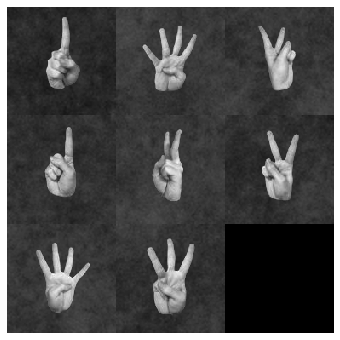

In [4]:
def plot_square_of_images(images):
    size=int(math.sqrt(len(images[0])))
    squaresize = math.ceil(math.sqrt(len(images)))
    im_row = []
    for row in range(squaresize):
        im_col=[]
        for col in range(squaresize):
            if col + squaresize * row < len(images):
                im = images[col + squaresize * row]
                im = im.reshape(size,size)
            else:
                im = np.zeros((size,size))
            im_col.append(im)
        rowofimages = np.concatenate(im_col,axis=1)
        im_row.append(rowofimages)
    squareofimages = np.concatenate(im_row,axis=0)
    flat_squareofimages = squareofimages.flatten()
    plot_image(flat_squareofimages)

sampleidx = sample(range(len(train)),8)
images = train.loc[sampleidx,'image'].reset_index(drop=True)

plt.figure(figsize=(6,6))
plot_square_of_images(images)


### Classic classifiers

### X: Explanatory variables

#### Create train/test sets

In [5]:
xtrain = np.vstack(train['image'])
xtrain.shape

(5000, 16384)

In [6]:
xtest = np.vstack(test['image'])
xtest.shape

(1000, 16384)

In [8]:
# no need to scale x ??? check
# is it better to scale after PCA ?

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# scaler.fit(xtrain)

# xtrain_s = scaler.transform(xtrain)
# xtest_s = scaler.transform(xtest)

xtrain_s = xtrain
xtest_s = xtest

xtrain_s[0]

array([54, 53, 51, ..., 65, 68, 70], dtype=uint8)

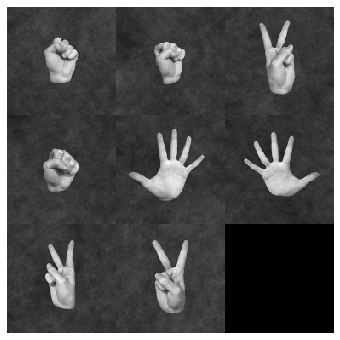

In [9]:
images = xtrain_s[:8]

plt.figure(figsize=(6,6))
plot_square_of_images(images)

#### PCA to speedup classifier training (keeping 95% of variance)

In [10]:
# very long on full training dataset 18000 instances. ~13minutes !
# may need to preprocess images before
# or use another PCA method: try incremental PCA

from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(xtrain_s)
t2 = time.time()
t2-t1

61.405547857284546

In [11]:
print('dimension reduction from %d to %d after PCA preserving 95%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 16384 to 408 after PCA preserving 95% of variance


In [12]:
from sklearn.decomposition import IncrementalPCA
t1 = time.time()
pca = IncrementalPCA(n_components=400,batch_size=1000)
X_reduced = pca.fit_transform(xtrain_s)
Xtest_reduced = pca.transform(xtest_s)
t2 = time.time()
t2-t1

19.263927459716797

Check how images looks like after inverse transform with PCA

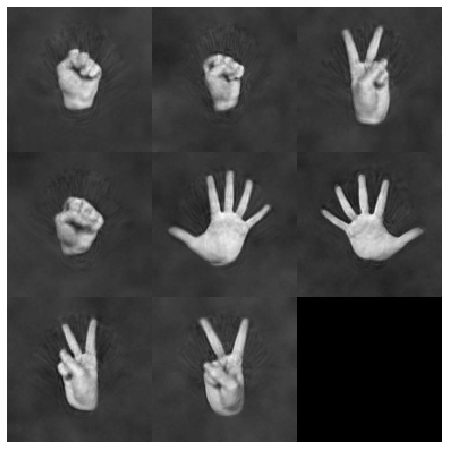

In [13]:
images = pca.inverse_transform(X_reduced[:8])

plt.figure(figsize=(8,8))
plot_square_of_images(images)

### Y: Responses

In [14]:
from sklearn.preprocessing import LabelEncoder

ytrainhand = train['hand']
encoderhand = LabelEncoder()
ytrainhand = encoderhand.fit_transform(ytrainhand)
print("ytrainhand: ",ytrainhand.shape)

# no need as already numericvalue
ytrainfinger = train['nbfinger']
print("ytrainfinger: ",ytrainfinger.shape)

ytrainmulti = train['fingerhand']
encodermulti = LabelEncoder()
ytrainmulti = encodermulti.fit_transform(ytrainmulti)
print("ytrainmulti: ",ytrainmulti.shape)

ytrainhand:  (5000,)
ytrainfinger:  (5000,)
ytrainmulti:  (5000,)


In [15]:
ytesthand = encoderhand.fit_transform(test['hand'])
print("ytesthand: ",ytesthand.shape)
ytestfinger = test['nbfinger']
print("ytestfinger: ",ytestfinger.shape)
ytestmulti = encodermulti.fit_transform(test['fingerhand'])
print("ytestmulti: ",ytestmulti.shape)


ytesthand:  (1000,)
ytestfinger:  (1000,)
ytestmulti:  (1000,)


### Train some classifiers to make first evaluation

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

classifs = [
           SGDClassifier(random_state=37), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(random_state=37),
           AdaBoostClassifier(random_state=37),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               'AdaBoost\t\t',
               ]

# Apply different classifiers
ytrain = ytrainmulti

t0 = time.time()
for name, clf in zip(classif_names, classifs):
    t1 = time.time()
    score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
    t2 = time.time()    
    print("%.2f seconds - %s Score :" % ((t2-t1),name),score, " Worst: %.4f" % score.min())

print('classifiers trained in %.2f seconds for %d instances\n' %((t2 - t0),len(xtrain_s)))


5.69 seconds - SGD		 Score : [0.97840432 0.97360528 0.9759904 ]  Worst: 0.9736
7.05 seconds - KNN		 Score : [0.99880024 0.99520096 0.99819928]  Worst: 0.9952
2.91 seconds - DecisionTree	 Score : [0.91661668 0.90641872 0.92917167]  Worst: 0.9064
7.28 seconds - SVC		 Score : [0.99940012 0.99940012 1.        ]  Worst: 0.9994
10.88 seconds - RandomForest	 Score : [0.99820036 0.99520096 0.99519808]  Worst: 0.9952
21.28 seconds - AdaBoost		 Score : [0.19496101 0.19256149 0.19147659]  Worst: 0.1915
classifiers trained in 55.08 seconds for 5000 instances



**--> SGD seems to bring very good results in significantly less time --> keep this one**

#### Keep one classifier

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(random_state=37)
score = cross_val_score(clf, X_reduced, ytrain, cv=5, scoring="accuracy")

score.min()

0.969

### Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

ytrain_pred = cross_val_predict(clf, X_reduced, ytrain, cv=3)

confmatr = confusion_matrix(ytrain, ytrain_pred)

pd.crosstab(encodermulti.inverse_transform(ytrain), encodermulti.inverse_transform(ytrain_pred), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0L,0R,1L,1R,2L,2R,3L,3R,4L,4R,5L,5R,All
True,,,,,,,,,,,,,
0L,410,1,0,0,0,0,0,0,0,0,0,0,411
0R,0,419,0,0,0,0,0,0,0,0,0,0,419
1L,3,1,381,7,2,3,1,2,0,0,0,1,401
1R,1,3,3,386,0,4,3,3,0,1,1,0,405
2L,0,1,10,0,416,11,4,5,2,2,0,1,452
2R,3,0,1,13,3,385,2,8,2,2,0,0,419
3L,0,0,0,0,0,0,417,0,1,0,0,0,418
3R,0,0,0,0,0,0,0,392,0,0,0,0,392
4L,1,0,0,0,0,0,2,0,416,1,0,0,420


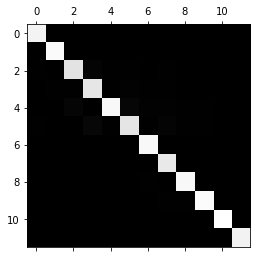

In [19]:
plt.matshow(confmatr,cmap=plt.cm.gray);

Make errors appears clearer

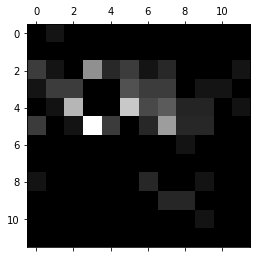

In [20]:
row_sums = confmatr.sum(axis=1,keepdims=True)
norm_conf_matr = confmatr / row_sums
np.fill_diagonal(norm_conf_matr,0)
plt.matshow(norm_conf_matr,cmap=plt.cm.gray);

Check miscategorized pictures

In [21]:
cl_2L = '2L'
cl_1L = '1L'
cl_2R = '2R'

c2L1L = X_reduced[(encodermulti.inverse_transform(ytrain) == cl_2L) & (encodermulti.inverse_transform(ytrain_pred) == cl_1L)]
c2L2R = X_reduced[(encodermulti.inverse_transform(ytrain) == cl_2L) & (encodermulti.inverse_transform(ytrain_pred) == cl_2R)]

2L classifed as 1L


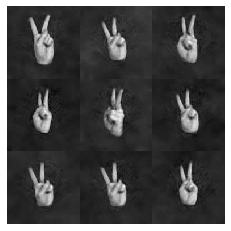

2L classifed as 2R


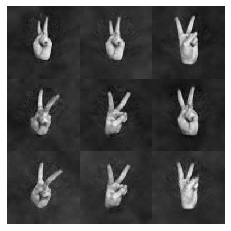

In [22]:
print('2L classifed as 1L')
plot_square_of_images(pca.inverse_transform(c2L1L[:9]))
plt.show()
print('2L classifed as 2R')
plot_square_of_images(pca.inverse_transform(c2L2R[:9]))
plt.show()

### Evaluate on test set

In [23]:
scoretest = cross_val_score(clf, Xtest_reduced, ytestmulti, cv=3, scoring="accuracy")
print("Score :" ,scoretest, " Worst: %.4f" % score.min())

Score : [0.97904192 0.97297297 0.96696697]  Worst: 0.9690


test score ~ = to train score --> model doesn't seem to overfit.

In [24]:
ytest_pred = cross_val_predict(clf, Xtest_reduced, ytestmulti, cv=3)

confmatr = confusion_matrix(ytestmulti, ytest_pred)
pd.crosstab(encodermulti.inverse_transform(ytestmulti), encodermulti.inverse_transform(ytest_pred), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0L,0R,1L,1R,2L,2R,3L,3R,4L,4R,5L,5R,All
True,,,,,,,,,,,,,
0L,88,0,0,0,0,0,0,0,0,0,0,0,88
0R,0,99,0,0,0,0,0,0,0,0,0,0,99
1L,2,0,82,1,0,0,1,0,0,0,0,0,86
1R,0,1,2,66,0,1,0,0,0,0,0,0,70
2L,0,0,4,0,80,3,1,1,0,0,0,0,89
2R,0,1,0,0,0,83,1,1,0,0,0,0,86
3L,0,0,0,0,0,0,73,0,0,1,0,0,74
3R,0,0,1,0,0,1,0,84,0,0,0,2,88
4L,0,0,0,0,0,0,0,0,71,1,0,0,72


## Using MLP

try using default parameters

In [25]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=37)

name='MLP Classifier'
t1 = time.time()
score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
t2 = time.time()    
print("%.2f seconds - %s Score :" % ((t2-t1),name),score, " Worst: %.4f" % score.min())

1.88 seconds - MLP Classifier Score : [0.97720456 0.97060588 0.98019208]  Worst: 0.9706


In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'hidden_layer_sizes':[(100,),(100,10)],
        'activation':['logistic', 'relu'],
        'solver':['sgd','adam'],
        'learning_rate_init':[0.001,0.01,0.1],
    }
]

clf = MLPClassifier(random_state=37)
grid_search = GridSearchCV(clf,param_grid,cv=3,return_train_score=True)
grid_search.fit(X_reduced,ytrain);

C:\MY_SOFTS\DEV\IDE\MiniConda\envs\finger\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\MY_SOFTS\DEV\IDE\MiniConda\envs\finger\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\MY_SOFTS\DEV\IDE\MiniConda\envs\finger\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\MY_SOFTS\DEV\IDE\MiniConda\envs\finger\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

C:\MY_SOFTS\DEV\IDE\MiniConda\envs\finger\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\MY_SOFTS\DEV\IDE\MiniConda\envs\finger\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [27]:
grid_search.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.1,
 'solver': 'sgd'}

In [28]:
grid_search.best_score_

0.9989999599119791

In [29]:

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic',hidden_layer_sizes=(100,),learning_rate_init=0.1,solver='sgd',random_state=37)

name='MLP Classifier'
t1 = time.time()
score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
t2 = time.time()    
print("%.2f seconds - %s Score :" % ((t2-t1),name),score, " Worst: %.4f" % score.min())


8.22 seconds - MLP Classifier Score : [0.99820036 1.         0.99879952]  Worst: 0.9982


In [30]:
ytrain_pred = cross_val_predict(clf, X_reduced, ytrain, cv=3)

confmatr = confusion_matrix(ytrain, ytrain_pred)

pd.crosstab(encodermulti.inverse_transform(ytrain), encodermulti.inverse_transform(ytrain_pred), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0L,0R,1L,1R,2L,2R,3L,3R,4L,4R,5L,5R,All
True,,,,,,,,,,,,,
0L,411,0,0,0,0,0,0,0,0,0,0,0,411
0R,0,419,0,0,0,0,0,0,0,0,0,0,419
1L,0,0,401,0,0,0,0,0,0,0,0,0,401
1R,0,0,0,404,0,1,0,0,0,0,0,0,405
2L,0,0,0,0,452,0,0,0,0,0,0,0,452
2R,0,0,0,0,1,418,0,0,0,0,0,0,419
3L,0,0,0,0,0,0,417,0,1,0,0,0,418
3R,0,0,0,0,0,1,0,391,0,0,0,0,392
4L,0,0,0,0,0,0,0,0,420,0,0,0,420


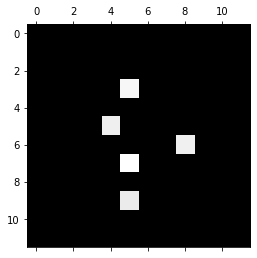

In [31]:
row_sums = confmatr.sum(axis=1,keepdims=True)
norm_conf_matr = confmatr / row_sums
np.fill_diagonal(norm_conf_matr,0)
plt.matshow(norm_conf_matr,cmap=plt.cm.gray);

### Evaluate on test set

In [32]:
scoretest = cross_val_score(clf, Xtest_reduced, ytestmulti, cv=3, scoring="accuracy")
print("Score :" ,scoretest, " Worst: %.4f" % score.min())

Score : [0.99101796 0.96996997 0.95795796]  Worst: 0.9982


test score ~ = to train score --> model doesn't seem to overfit.

In [33]:
ytest_pred = cross_val_predict(clf, Xtest_reduced, ytestmulti, cv=3)

confmatr = confusion_matrix(ytestmulti, ytest_pred)
pd.crosstab(encodermulti.inverse_transform(ytestmulti), encodermulti.inverse_transform(ytest_pred), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0L,0R,1L,1R,2L,2R,3L,3R,4L,4R,5L,5R,All
True,,,,,,,,,,,,,
0L,87,1,0,0,0,0,0,0,0,0,0,0,88
0R,0,99,0,0,0,0,0,0,0,0,0,0,99
1L,0,0,79,5,1,0,1,0,0,0,0,0,86
1R,0,1,1,66,0,2,0,0,0,0,0,0,70
2L,0,0,1,1,86,1,0,0,0,0,0,0,89
2R,0,0,0,0,2,84,0,0,0,0,0,0,86
3L,0,0,0,0,1,0,71,2,0,0,0,0,74
3R,0,0,0,0,0,4,1,83,0,0,0,0,88
4L,0,0,0,0,0,0,0,0,72,0,0,0,72


## Using Keras and TensorFlow

In [183]:
import tensorflow as tf
from tensorflow import keras

In [184]:
tf.__version__

'2.1.0'

In [185]:
keras.__version__

'2.2.4-tf'

In [186]:
xflat = train['image']

f = lambda x: x.reshape(128,128)
x_reshaped = xflat.apply(f)
xtrain = np.vstack(x_reshaped)

xtrain = xtrain.reshape(5000,128,128)
xtrain = xtrain/255.

xflat = test['image']
x_reshaped = xflat.apply(f)
xtest = np.vstack(x_reshaped)

xtest = xtest.reshape(1000,128,128)
xtest = xtest/255.

xtrain.shape

(5000, 128, 128)

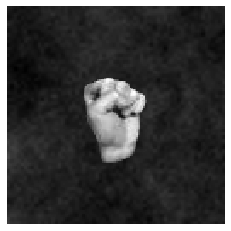

In [187]:
plt.imshow(xtrain[1],mpl.cm.gray)
plt.axis('off')
plt.show()

In [188]:
ytrainmulti = train['fingerhand']
encodermulti = LabelEncoder()
ytrainmulti = encodermulti.fit_transform(ytrainmulti)
print("ytrainmulti: ",ytrainmulti.shape)

ytestmulti = test['fingerhand']
ytestmulti = encodermulti.transform(ytestmulti)

ytrainmulti:  (5000,)


In [189]:
ytrainmulti[:10]

array([ 0,  0,  4,  0, 10, 11,  5,  5,  6,  1])

In [244]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[128, 128]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dense(12, activation="softmax"))

In [232]:
keras.backend.clear_session()
np.random.seed(37)
tf.random.set_seed(37)

In [212]:
model.layers

In [213]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               4915500   
_________________________________________________________________
dense_1 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                612       
Total params: 4,931,162
Trainable params: 4,931,162
Non-trainable params: 0
_________________________________________________________________


In [214]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [215]:
model.get_layer(hidden1.name) is hidden1

True

In [216]:
weights, biases = hidden1.get_weights()
weights

array([[-1.5917886e-02,  1.5225252e-02,  8.0684107e-03, ...,
        -4.3964945e-04, -3.8895197e-04, -1.7346611e-02],
       [ 3.0648615e-03, -1.7706148e-02,  1.2637557e-02, ...,
         1.6155886e-02,  1.1015175e-02, -7.8074140e-03],
       [-7.5279325e-03, -1.4947493e-02, -1.6820515e-02, ...,
        -1.0630772e-02,  8.5082687e-03, -1.6379414e-02],
       ...,
       [ 8.4251165e-03, -3.5353005e-05,  1.6399920e-03, ...,
         2.9632617e-03, -1.0110187e-02,  1.2448290e-02],
       [-4.0590866e-03,  1.8440193e-02,  1.8694410e-02, ...,
        -1.1674548e-02, -1.2724101e-02, -1.4976131e-02],
       [ 1.5932159e-02, -6.0369037e-03,  1.8248441e-02, ...,
         8.3110537e-03,  2.9250439e-03,  1.6335240e-02]], dtype=float32)

In [217]:
weights.shape

(16384, 300)

In [245]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [246]:
xtrain_split=xtrain[:4000]
xvalid_split=xtrain[1000:]
ytrain_split=ytrainmulti[:4000]
yvalid_split=ytrainmulti[1000:]

history = model.fit(xtrain_split, ytrain_split, epochs=20,
                    validation_data=(xvalid_split, yvalid_split))

Train on 4000 samples, validate on 4000 samples
Epoch 1/20
4000/4000 [==============================] - 2s 434us/sample - loss: 1.7197 - sparse_categorical_accuracy: 0.4790 - val_loss: 1.1682 - val_sparse_categorical_accuracy: 0.6317
Epoch 2/20
4000/4000 [==============================] - 1s 329us/sample - loss: 0.6999 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.4295 - val_sparse_categorical_accuracy: 0.9345
Epoch 3/20
4000/4000 [==============================] - 1s 335us/sample - loss: 0.3487 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.2947 - val_sparse_categorical_accuracy: 0.9457
Epoch 4/20
4000/4000 [==============================] - 1s 332us/sample - loss: 0.2332 - sparse_categorical_accuracy: 0.9548 - val_loss: 0.1773 - val_sparse_categorical_accuracy: 0.9715
Epoch 5/20
4000/4000 [==============================] - 1s 335us/sample - loss: 0.1618 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.1540 - val_sparse_categorical_accuracy: 0.9747
Epoch 6/20
4000/4000 [

In [247]:
history.params

{'batch_size': 32,
 'epochs': 20,
 'steps': 125,
 'samples': 4000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss',
  'sparse_categorical_accuracy',
  'val_loss',
  'val_sparse_categorical_accuracy']}

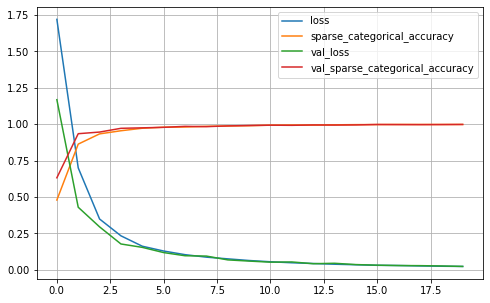

In [248]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

In [249]:
model.evaluate(xtest, ytestmulti)

1000/1000 [==============================] - 0s 232us/sample - loss: 0.0366 - sparse_categorical_accuracy: 0.9920


[0.03662880447506905, 0.992]

In [250]:
y_pred = model.predict_classes(xtest)

pd.crosstab(encodermulti.inverse_transform(ytestmulti), encodermulti.inverse_transform(y_pred), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0L,0R,1L,1R,2L,2R,3L,3R,4L,4R,5L,5R,All
True,,,,,,,,,,,,,
0L,88,0,0,0,0,0,0,0,0,0,0,0,88
0R,0,99,0,0,0,0,0,0,0,0,0,0,99
1L,0,0,86,0,0,0,0,0,0,0,0,0,86
1R,0,0,1,69,0,0,0,0,0,0,0,0,70
2L,0,0,2,0,87,0,0,0,0,0,0,0,89
2R,0,0,0,0,0,85,0,1,0,0,0,0,86
3L,0,0,0,0,2,0,72,0,0,0,0,0,74
3R,0,0,0,0,0,1,0,87,0,0,0,0,88
4L,0,0,0,0,0,0,0,0,72,0,0,0,72


In [251]:
sampleidx = sample(range(len(xtest)),9)

X_new = xtest[sampleidx]
y_pred = model.predict_classes(X_new)
encodermulti.inverse_transform(y_pred)

array(['4L', '5R', '1L', '0R', '4R', '1L', '5L', '0L', '5L'], dtype=object)

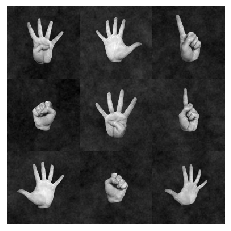

In [252]:
X_new.shape
X_flat=[x.flatten() for x in X_new]
plot_square_of_images(X_flat)